# Plotting Figure S8

This script is used to show the changes in urban heat waves intensity by the year 2070.

ref: https://towardsdatascience.com/histograms-and-density-plots-in-python-f6bda88f5ac0  

In [1]:
import xarray as xr
import datetime
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import time
import gc
import util
import seaborn as sns
from scipy.stats import gaussian_kde

In [2]:
def select_data(df, lat_min, lat_max, lon_min, lon_max):
    df_copy = df.copy().reset_index()
    df_copy["lon"] = np.where(df_copy['lon'] <= 180, df_copy['lon'], df_copy['lon']-360)
    df_final = df_copy[(df_copy["lat"] > lat_min) & (df_copy["lat"] < lat_max) & (df_copy["lon"] > lon_min) & (df_copy["lon"] < lon_max)]
    return df_final

def plot_in_kde(df, ax, model_ls,color_type,linewidth,label=None,alpha=None):
    for model_name in model_ls:
            sns.distplot(df[model_name], ax=ax, hist=False, kde=True, 
                         kde_kws={'linewidth': linewidth,
                                  'alpha': alpha},
                         color=color_type,
                         label=label)
            label=None
    #plt.xlabel('Increased Intensity ($\Delta T$), K')
    #plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    
def simple_bootstrap(x, sample_num, reps):

    xb = np.random.choice(x, (reps, sample_num))
    mb = np.nanmean(xb,axis=1)
    mb.sort()
    
    #print(xb.shape)
    #print(mb.shape)
    #return np.nanmean(mb), np.nanstd(mb), np.nanpercentile(mb, [2.5, 97.5])
    return np.nanpercentile(mb, [5, 95])

# return entire cdf and corresponding idx
def get_cdf(insert_size_distribution):
    """Calculate cumulative distribution function from the raw insert size
    distributin. Uses 1D kernel density estimation.

    Args:
        insert_size_distribution (list): list of insert sizes from aligned
        read pairs

    Returns:
        1darray: a cumulative density function
        
    Ref: https://www.programcreek.com/python/example/100320/scipy.stats.gaussian_kde
    """
    kde = gaussian_kde(
        insert_size_distribution)
        #bw_method=0.2 / np.std(insert_size_distribution, ddof=1))
    x_grid = np.linspace(
        -2,
        6, 10000)
    kde = kde.evaluate(x_grid)
    cdf = np.cumsum(kde)
    cdf = cdf / cdf[-1]
    return x_grid, cdf 

# get the nearest value and corresponding idx
def get_index_value(ar, val):
    idx = np.argmin(np.abs(np.array(ar)-val))
    return ar[idx], idx

# entire workflow combing get_cdf() and get_index_value(), 
# which returns the CESM cdf value and CMIP cdf value for certain percentile 
def get_CMIP_sf_from_CESM(CESM_data, CMIP_data, set_per):
    x_grid_CESM, cdf_CESM=get_cdf(CESM_data)
    x_grid_CMIP, cdf_CMIP=get_cdf(CMIP_data)
    cdf_val_CESM, cdf_idx_CESM = get_index_value(cdf_CESM,np.percentile(cdf_CESM, set_per))
    cdf_val_CMIP = 1 - cdf_CMIP[cdf_idx_CESM]
    
    return cdf_val_CESM, cdf_val_CMIP

def get_CMIP_sf_from_CESM_pdf(CESM_pdf, CMIP_pdf, set_per):
    cdf_CESM = np.cumsum(CESM_pdf)
    cdf_CESM = cdf_CESM / cdf_CESM[-1]
    
    cdf_CMIP = np.cumsum(CMIP_pdf)
    cdf_CMIP = cdf_CMIP / cdf_CMIP[-1]
    
    cdf_val_CESM, cdf_idx_CESM = get_index_value(cdf_CESM,set_per)
    sf_val_CMIP = 1 - cdf_CMIP[cdf_idx_CESM]
    
    return cdf_val_CESM, sf_val_CMIP

## Plotting intensity between 2061 and 2006

GL
CESM mean: 0.72
CESM std: 0.15
CMIP mean: 1.59
CMIP std: 0.30
CESM cdf val: 99.99 %
CESM sf val: 0.01 %
CMIP cdf val: 84.40 %
CMIP sf val: 15.60 %
Years for CMIP sf: 6


SE
CESM mean: 1.34
CESM std: 0.17
CMIP mean: 1.64
CMIP std: 0.26
CESM cdf val: 99.99 %
CESM sf val: 0.01 %
CMIP cdf val: 94.03 %
CMIP sf val: 5.97 %
Years for CMIP sf: 17


CI
CESM mean: 0.74
CESM std: 0.35
CMIP mean: 1.24
CMIP std: 0.29
CESM cdf val: 99.99 %
CESM sf val: 0.01 %
CMIP cdf val: 98.41 %
CMIP sf val: 1.59 %
Years for CMIP sf: 63


NC
CESM mean: 0.94
CESM std: 0.16
CMIP mean: 1.42
CMIP std: 0.28
CESM cdf val: 99.99 %
CESM sf val: 0.01 %
CMIP cdf val: 89.40 %
CMIP sf val: 10.60 %
Years for CMIP sf: 9




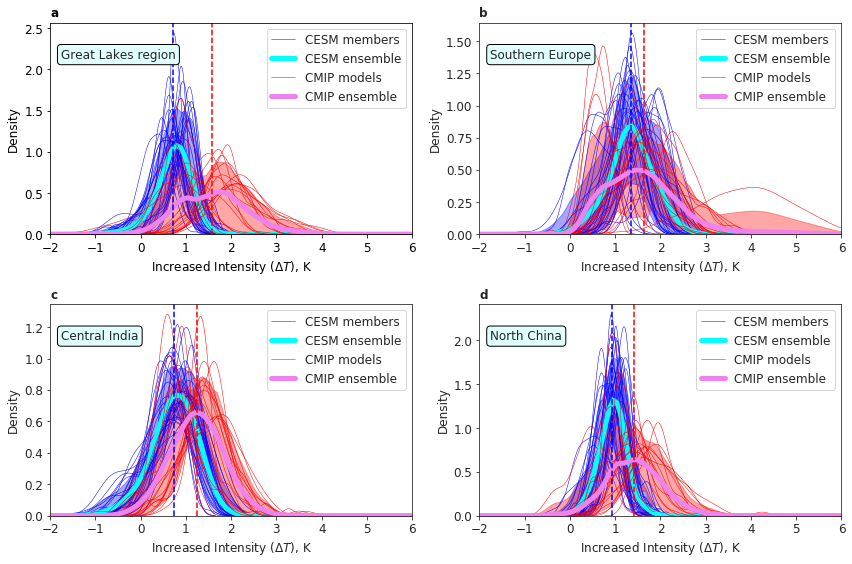

In [3]:
rc={'axes.labelsize': 12, 'font.size': 12, 'legend.fontsize': 12, 'axes.titlesize': 12}
plt.rcParams.update(**rc)

CMIP={}
CMIP["diff_raw"]={}
CMIP["diff_stat"]={}
CMIP_path="../data/uhws_min/UHWs_CMIP/"

for year in ["2006","2061"]:
    CMIP[year]={}
    for vari in ["intensity"]: #["frequency","totaldays","intensity","percentile"]:
        CMIP[year][vari]=pd.read_csv(CMIP_path+year+"_"+vari+".csv").set_index(["lat","lon"])
    #CMIP[year]["duration"]=CMIP[year]["totaldays"]/CMIP[year]["frequency"]

for vari in ["intensity"]: #["frequency","totaldays","intensity","duration","percentile"]:
    CMIP["diff_raw"][vari] = CMIP["2061"][vari]-CMIP["2006"][vari]
    CMIP["diff_stat"][vari+"_diff_mean"] = CMIP["diff_raw"][vari].mean(axis=1)
    CMIP["diff_stat"][vari+"_diff_std"] = CMIP["diff_raw"][vari].std(axis=1)
    #CMIP["diff_stat"][vari+"_diff_0.025"] = CMIP["diff_raw"][vari].quantile(0.025,axis=1)
    CMIP["diff_stat"][vari+"_diff_SNR"] = CMIP["diff_stat"][vari+"_diff_mean"].abs()/CMIP["diff_stat"][vari+"_diff_std"]
    
    
CESM={}
CESM["diff_raw"]={}
CESM["diff_stat"]={}
CESM_path="../data/uhws_min/UHWs_CESM/"

for year in ["2006","2061"]:
    CESM[year]={}
    for vari in ["intensity"]: #["frequency","totaldays","intensity","percentile"]:
        CESM[year][vari]=pd.read_csv(CESM_path+year+"_"+vari+".csv").set_index(["lat","lon"])
    #CESM[year]["duration"]=CESM[year]["totaldays"]/CESM[year]["frequency"]

for vari in ["intensity"]: #["frequency","totaldays","intensity","duration","percentile"]:
    CESM["diff_raw"][vari] = CESM["2061"][vari]-CESM["2006"][vari]
    CESM["diff_stat"][vari+"_diff_mean"] = CESM["diff_raw"][vari].mean(axis=1)
    CESM["diff_stat"][vari+"_diff_std"] = CESM["diff_raw"][vari].std(axis=1)
    #CESM["diff_stat"][vari+"_diff_0.025"] = CESM["diff_raw"][vari].quantile(0.025,axis=1)
    CESM["diff_stat"][vari+"_diff_SNR"] = CESM["diff_stat"][vari+"_diff_mean"].abs()/CESM["diff_stat"][vari+"_diff_std"]


# merge CMIP with CESM member 002
merge_ens={}

for vari in ["intensity"]:
    merge_ens[vari]=pd.concat([CMIP["diff_raw"][vari].reset_index(),
                    CESM["diff_raw"][vari]["002_min"].reset_index()["002_min"]],
                    axis=1).set_index(["lat","lon"])
    merge_ens[vari+"_diff_mean"]=merge_ens[vari].mean(axis=1)
    merge_ens[vari+"_diff_std"]=merge_ens[vari].std(axis=1)
    merge_ens[vari+"_diff_SNR"]=merge_ens[vari+"_diff_mean"].abs()\
                                /merge_ens[vari+"_diff_std"]

"""
CMIP_region_data={}
CMIP_region_data["NC"]=select_data(CMIP["diff_raw"]["intensity"], 32, 45, 110, 123)
CMIP_region_data["CI"]=select_data(CMIP["diff_raw"]["intensity"], 18, 25, 75, 87)
CMIP_region_data["GL"]=select_data(CMIP["diff_raw"]["intensity"], 36.15, 49.5, -95, -75)
CMIP_region_data["SE"]=select_data(CMIP["diff_raw"]["intensity"], 40, 50, 15, 30)
"""
merge_ens_region_data={}
merge_ens_region_data["NC"]=select_data(merge_ens["intensity"], 32, 45, 110, 123)
merge_ens_region_data["CI"]=select_data(merge_ens["intensity"], 18, 25, 75, 87)
merge_ens_region_data["GL"]=select_data(merge_ens["intensity"], 36.15, 49.5, -95, -75)
merge_ens_region_data["SE"]=select_data(merge_ens["intensity"], 40, 50, 15, 30)


CESM_region_data={}
CESM_region_data["NC"]=select_data(CESM["diff_raw"]["intensity"], 32, 45, 110, 123)
CESM_region_data["CI"]=select_data(CESM["diff_raw"]["intensity"], 18, 25, 75, 87)
CESM_region_data["GL"]=select_data(CESM["diff_raw"]["intensity"], 36.15, 49.5, -95, -75)
CESM_region_data["SE"]=select_data(CESM["diff_raw"]["intensity"], 40, 50, 15, 30)

"""
global_map_plot(NC, "TREFMXAV_U", -0.15, 2, "rainbow", reset_lon=False)
global_map_plot(CI, "TREFMXAV_U", -0.15, 2, "rainbow", reset_lon=False)
global_map_plot(GL, "TREFMXAV_U", -0.15, 2, "rainbow", reset_lon=False)
global_map_plot(SE, "TREFMXAV_U", -0.15, 2, "rainbow", reset_lon=False)
"""


region_area_ls = ["GL","SE","CI","NC"]
var_text_dict={"GL":"Great Lakes region",
               "SE":"Southern Europe",
               "CI":"Central India",
               "NC":"North China"}

title_text_dict={"GL":"a",
                 "SE":"b",
                 "CI":"c",
                 "NC":"d"}


model_ls = ["ACCESS1-0", "ACCESS1-3", "CanESM2", "CNRM-CM5", "CSIRO-Mk3-6-0",
            "GFDL-CM3", "GFDL-ESM2G", "GFDL-ESM2M", "HadGEM2-CC","FGOALS-s2",
            "HadGEM2-ES", "IPSL-CM5A-MR", "MIROC5", "MIROC-ESM", "MIROC-ESM-CHEM",
            "MRI-CGCM3", "MRI-ESM1","002_min"]

member_ls = []
for i in range(2,34):
    member_idx = (str(i).zfill(3))
    member_ls.append(member_idx+"_min")

ind=np.linspace(-2,6,101)

fig = plt.figure(figsize=(12,8))
for i in range(4):
    ax = plt.subplot(2,2,i+1)
    region_area = region_area_ls[i]
    print(region_area)
    sns.set_style("ticks")    
    
    # CESM
    # different members
    plot_in_kde(CESM_region_data[region_area], ax,member_ls,
                color_type="b",linewidth=0.5,label="CESM members")
    # uncertainty of members
    dist_CESM=np.zeros((101,len(member_ls)))
    for i in range(len(member_ls)):
        model=member_ls[i]
        kde_kernel=gaussian_kde(CESM_region_data[region_area][model].dropna())
        dist_CESM[:,i]=kde_kernel.evaluate(ind)
    dist_uncertainty_CESM = np.apply_along_axis(simple_bootstrap, 1, dist_CESM, 2, 10000)
    ax.fill_between(ind, dist_uncertainty_CESM[:,0], dist_uncertainty_CESM[:,1],color="b",alpha=0.35) 
    # average of the kdes
    ax.plot(ind, dist_CESM.mean(axis=1),color="cyan",linewidth=5,label="CESM ensemble")    
   
    
    # merge_ens
    # different models
    plot_in_kde(merge_ens_region_data[region_area], ax, model_ls,
                color_type="r",linewidth=0.5,label="CMIP models")
    # uncertainty of models
    dist_merge_ens=np.zeros((101,len(model_ls)))
    for i in range(len(model_ls)):
        model=model_ls[i]
        kde_kernel=gaussian_kde(merge_ens_region_data[region_area][model].dropna())
        dist_merge_ens[:,i]=kde_kernel.evaluate(ind)
    dist_uncertainty_merge_ens = np.apply_along_axis(simple_bootstrap, 1, dist_merge_ens, 2, 10000)
    ax.fill_between(ind, dist_uncertainty_merge_ens[:,0], dist_uncertainty_merge_ens[:,1],color="r",alpha=0.35)
    # average of kdes
    ax.plot(ind, dist_merge_ens.mean(axis=1),color="violet",linewidth=5,label="CMIP ensemble")   
    
    
    CESM_mean = CESM_region_data[region_area].set_index(["lat","lon"]).mean(axis=1).mean(axis=0)
    CESM_std = CESM_region_data[region_area].set_index(["lat","lon"]).mean(axis=1).std(axis=0)
    merge_ens_mean = merge_ens_region_data[region_area].set_index(["lat","lon"]).mean(axis=1).mean(axis=0)
    merge_ens_std = merge_ens_region_data[region_area].set_index(["lat","lon"]).mean(axis=1).std(axis=0)
    
    ax.axvline(CESM_mean,color="b",linestyle="dashed")
    print("CESM mean:",'{:.2f}'.format(CESM_mean))
    print("CESM std:",'{:.2f}'.format(CESM_std))
    ax.axvline(merge_ens_mean,color="red",linestyle="dashed")
    print("CMIP mean:",'{:.2f}'.format(merge_ens_mean))
    print("CMIP std:",'{:.2f}'.format(merge_ens_std))
     
    cdf_val_CESM, sf_val_merge_ens = get_CMIP_sf_from_CESM_pdf(
                                CESM_pdf=dist_CESM.mean(axis=1), 
                                CMIP_pdf=dist_merge_ens.mean(axis=1), 
                                set_per=0.9999)
    print("CESM cdf val:", '{:.2f}'.format(cdf_val_CESM*100),"%")
    print("CESM sf val:", '{:.2f}'.format((1-cdf_val_CESM)*100),"%")
    print("CMIP cdf val:", '{:.2f}'.format((1-sf_val_merge_ens)*100),"%")
    print("CMIP sf val:", '{:.2f}'.format(sf_val_merge_ens*100),"%")
    print("Years for CMIP sf:", '{:.0f}'.format(1/sf_val_merge_ens))
    
    ax.legend()
    ax.set_ylim(bottom=0)
    ax.set_xlim(-2,6)
    ax.set_xlabel('Increased Intensity ($\Delta T$), K')#,fontsize=28)
    ax.set_ylabel('Density')
    
    props = dict(boxstyle='round', edgecolor='black',facecolor='lightcyan')
    ax.text(0.03, 0.88, var_text_dict[region_area], transform=ax.transAxes, fontsize=12,
             verticalalignment='top', bbox=props,zorder=6)
    ax.set_title(title_text_dict[region_area], fontweight="bold", loc="left")
    
    print("\n")
    #sns.set(font_scale = 2)
    
plt.tight_layout()    
plt.savefig("../figures/intensity_min.pdf",dpi=188)
plt.show()